# Loading Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
melb = pd.read_csv('melb_data.csv')
print(melb.shape)
melb.head(3)

(13580, 21)


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


# Preprocessing

In [3]:
melb.isnull().any()

Suburb           False
Address          False
Rooms            False
Type             False
Price            False
Method           False
SellerG          False
Date             False
Distance         False
Postcode         False
Bedroom2         False
Bathroom         False
Car               True
Landsize         False
BuildingArea      True
YearBuilt         True
CouncilArea       True
Lattitude        False
Longtitude       False
Regionname       False
Propertycount    False
dtype: bool

In [18]:
car_average = melb[melb.Car != np.nan].Car.mean()
print(car_average)
melb.Car = melb.Car.replace(np.nan, car_average)
not melb.Car.isnull().any()

1.6095729013254787


True

In [22]:
# remove indecisible features
melb = melb.dropna(axis=0)
melb.isnull().any()

Suburb           False
Address          False
Rooms            False
Type             False
Price            False
Method           False
SellerG          False
Date             False
Distance         False
Postcode         False
Bedroom2         False
Bathroom         False
Car              False
Landsize         False
BuildingArea     False
YearBuilt        False
CouncilArea      False
Lattitude        False
Longtitude       False
Regionname       False
Propertycount    False
dtype: bool

# EDA

<AxesSubplot:xlabel='Rooms', ylabel='Price'>

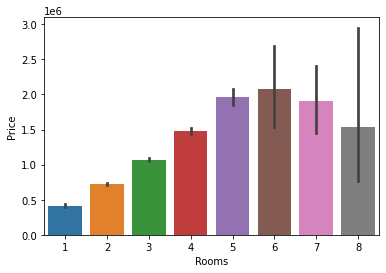

In [49]:
sns.barplot(data=melb, x='Rooms', y='Price')

<AxesSubplot:xlabel='Bathroom', ylabel='Price'>

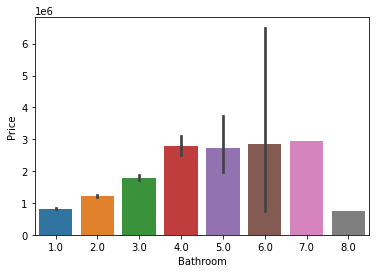

In [50]:
sns.barplot(data=melb, x='Bathroom', y='Price')

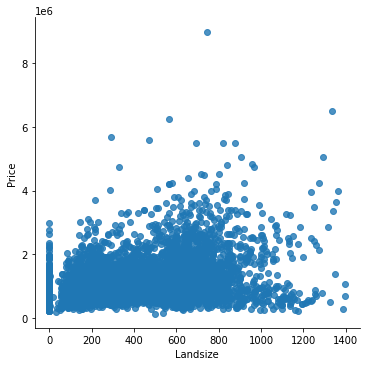

In [57]:
sns.lmplot(data=melb[melb.Landsize < 1400], x='Landsize', y='Price', fit_reg=False)

# Defining a model

In [66]:
features = ['Rooms', 'Bathroom', 'Lattitude', 'Landsize', 'Longtitude']
X = melb[features]
X.describe()

,Rooms,Bathroom,Lattitude,Landsize,Longtitude
count,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000
mean,2.931407,1.576340,-37.807904,471.006940,144.990201
std,0.971079,0.711362,0.075850,897.449881,0.099165
min,1.000000,1.000000,-38.164920,0.000000,144.542370
25%,2.000000,1.000000,-37.855438,152.000000,144.926198
50%,3.000000,1.000000,-37.802250,373.000000,144.995800
75%,4.000000,2.000000,-37.758200,628.000000,145.052700
max,8.000000,8.000000,-37.457090,37000.000000,145.526350


In [68]:
print(X.shape)
X.head(3)

(6196, 5)


,Rooms,Bathroom,Lattitude,Landsize,Longtitude
1,2,1.0,-37.8079,156.0,144.9934
2,3,2.0,-37.8093,134.0,144.9944
4,4,1.0,-37.8072,120.0,144.9941


In [69]:
y = melb.Price
print(y.shape)
y.head(3)

(6196,)


1    1035000.0
2    1465000.0
4    1600000.0
Name: Price, dtype: float64

# Training

In [86]:
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [87]:
# model = DecisionTreeRegressor(random_state=1)
model = RandomForestRegressor(random_state=1)
model.fit(X, y)

RandomForestRegressor(random_state=1)

# Evaluation/Validation

In [88]:
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split

In [89]:
prediction = cross_val_predict(model, X, y, cv=5)
prediction

array([1082665.        , 1244270.        , 1366375.        , ...,
        560470.66666667,  576260.        , 2335940.        ])

In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
RMSLE = np.sqrt(mean_squared_log_error(prediction, y))
# 1st iteration - DecisionTreeRegressor
# 0.32845... 굉장히 좋은 점수! - 'Rooms', 'Bathroom', 'Lattitude', 'Longtitude', 'Landsize'
# 0.39 Landsize를 뺐더니 더 점수가 나빠졌다
# 2st iteration - RandomForestRegressor
# 0.25495... 훨씬 좋은 점수!
RMSLE

0.254950350965006

In [91]:
# checking real estimate difference /w hold out evaluation
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)
model_alt = DecisionTreeRegressor()
model_alt.fit(train_X, train_y)
prediction_alt = model_alt.predict(val_X)
# DecisionTree 273,000$ error margin - 273331.192...
# RandomForest 274,643$ error margin - 274643.006... 에러마진은 더 낮아졌음.
# 아마도 hold out된 부분이 그렇지 않은 부분에 비하여 가격특이점이 있는 듯
mean_absolute_error(val_y, prediction_alt)

274643.0066709705

# Prediction

In [45]:
model.predict(X)

array([1035000., 1465000., 1600000., ...,  385000.,  560000., 2450000.])